In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

income = pd.read_csv("../Data/income.csv")

income.head()

,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,45,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,28,United-States,"less than or equal to 50,000"
1,24,Federal-gov,HS-grad,Never-married,Armed-Forces,Own-child,White,Male,0,0,40,United-States,"less than or equal to 50,000"
2,44,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,"greater than 50,000"
3,27,Private,9th,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,"less than or equal to 50,000"
4,20,Private,Some-college,Never-married,Sales,Not-in-family,White,Male,0,0,35,United-States,"less than or equal to 50,000"


In [2]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop("SalStat", axis=1), 
        drop_first=True
    )
    X = data.drop("target", axis=1)
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = income_model_prep(income) 

# Assignment 1: Simple Tree

1. Build a decision tree with max_depth 3 using the `age`, `hoursperweek` and `gender` features.
2. Calculate accuracy and build a confusion matrix for the test data
3. Plot the tree - which group has the highest probability of making over 50,000?
4. Plot Feature importance - which variable was most important? Are there any we can drop?

In [4]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3)

dt.fit(X_train, y_train)

print(f"Train Accuracy: {dt.score(X_train, y_train)}")
print(f"Test Accuracy: {dt.score(X_test, y_test)}")

Train Accuracy: 0.8194042686263779
Test Accuracy: 0.8258286429018137


In [5]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, dt.predict(X_test))

array([[4853,   28],
       [1086,  429]])

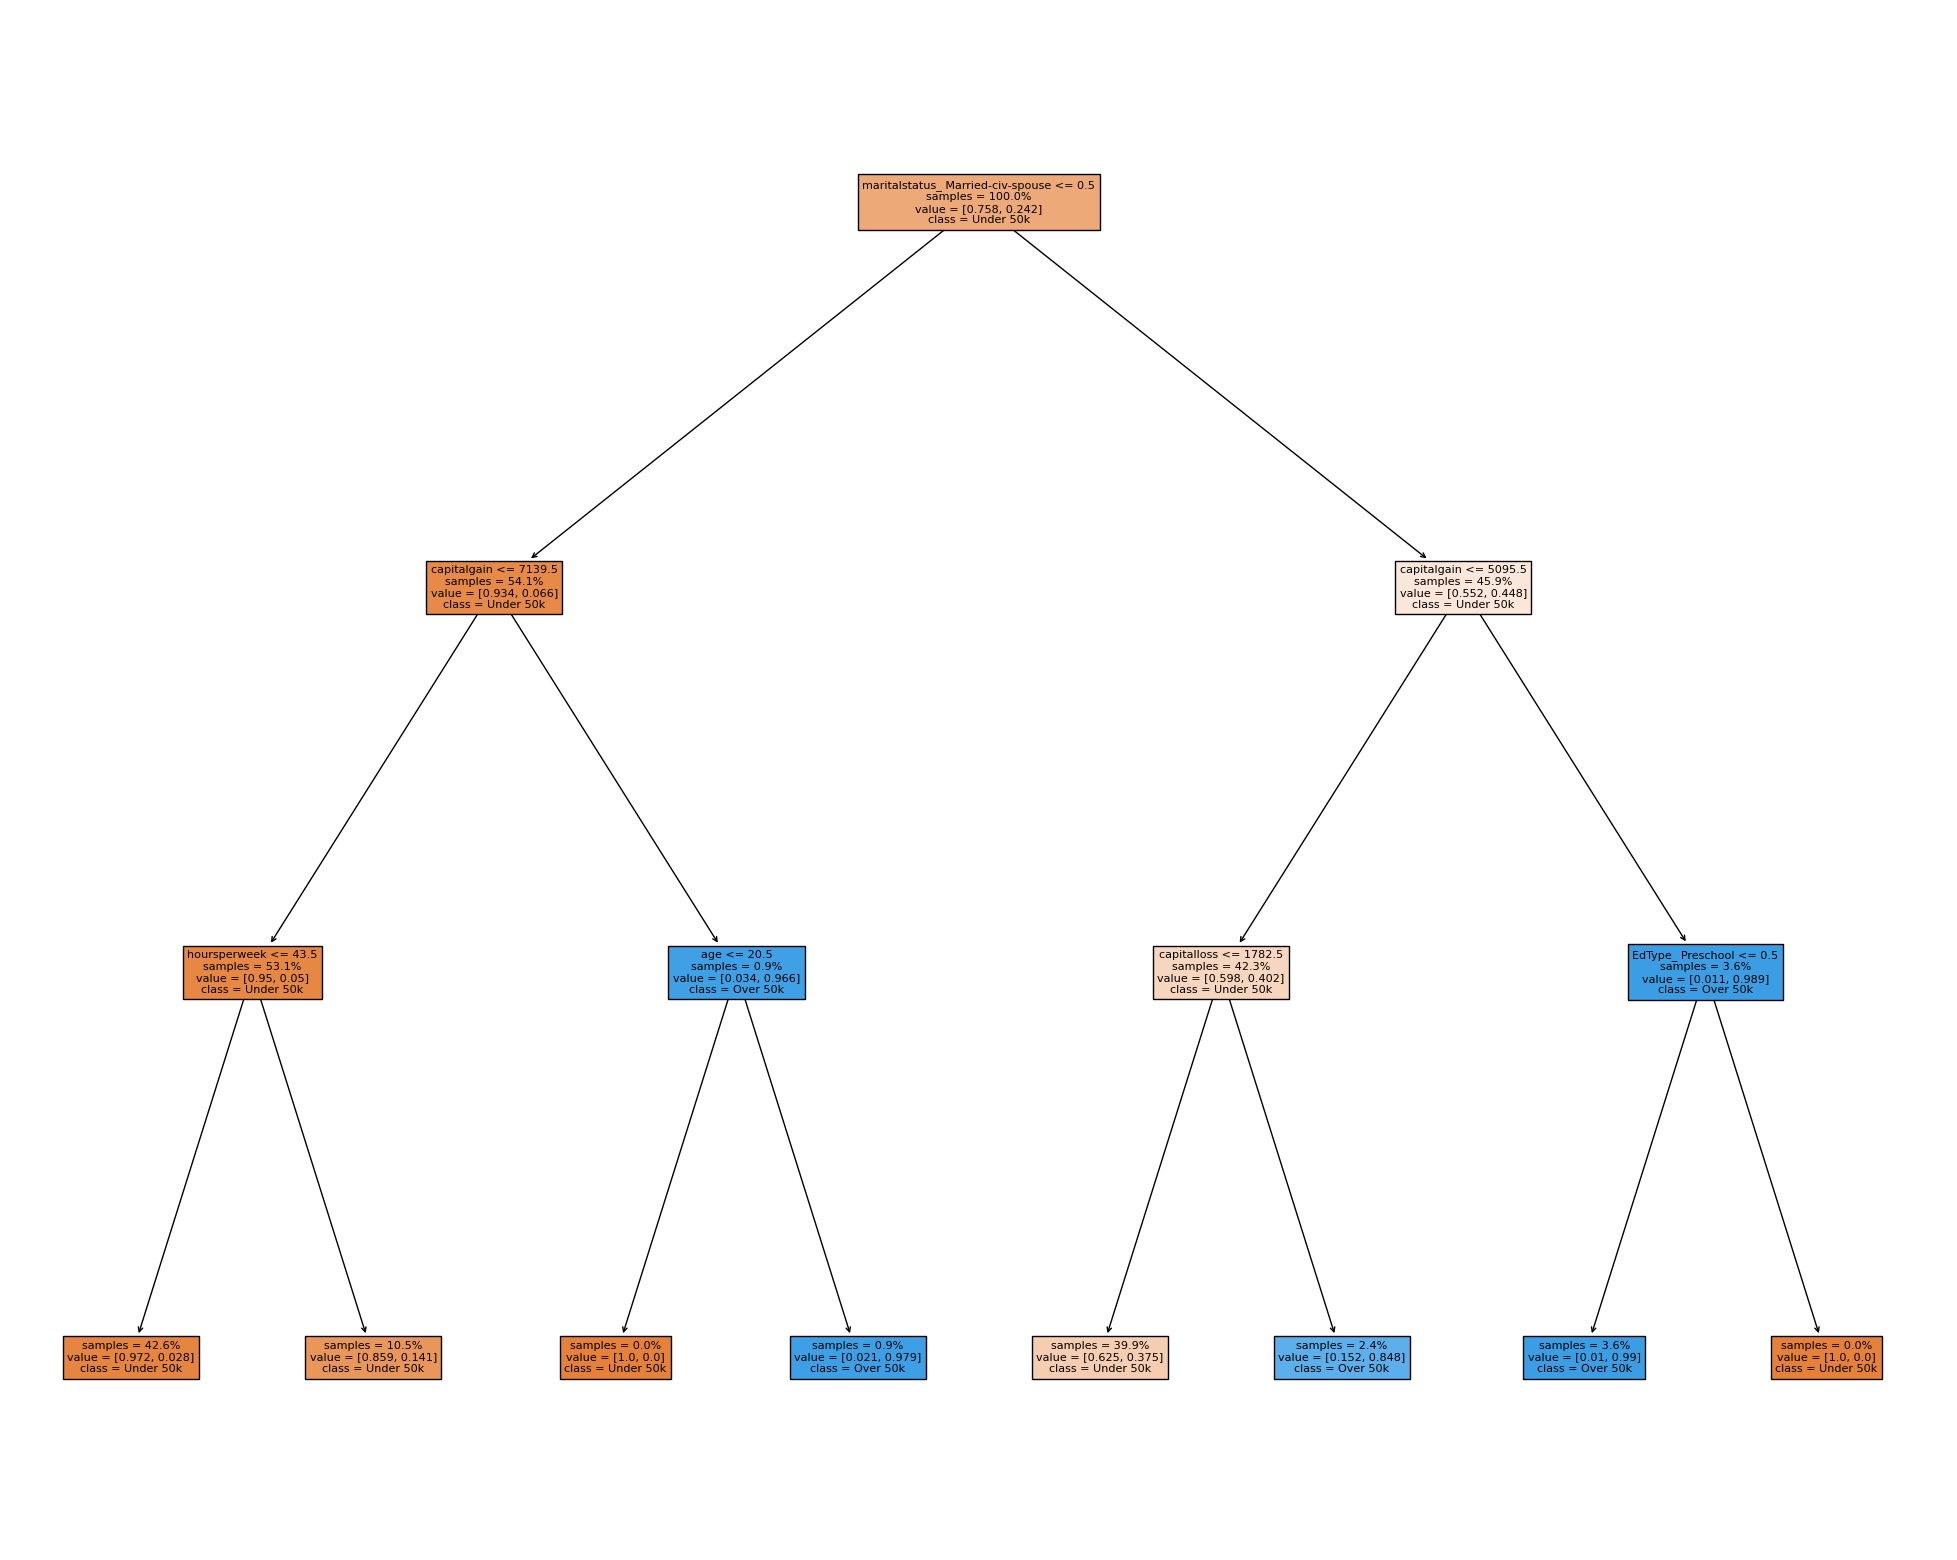

In [6]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 20))

plot_tree(
    dt,
    feature_names=list(X_test.columns),
    class_names=["Under 50k", "Over 50k"],
    impurity=False,
    proportion=True,
    filled=True
);

In [7]:
sorted(dt.feature_importances_)[::-1][:6]

[0.5876885722502053,
 0.31055525062854655,
 0.0816120216562176,
 0.01773054015702866,
 0.0017941846659642229,
 0.0006194306420375588]

In [8]:
importance_df = (
    pd.DataFrame({
        "feature": X_train.columns, 
        "importance": dt.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

importance_df

,feature,importance
27,maritalstatus_ Married-civ-spouse,0.587689
1,capitalgain,0.310555
2,capitalloss,0.081612
3,hoursperweek,0.017731
0,age,0.001794
...,...,...
32,occupation_ Adm-clerical,0.000000
31,maritalstatus_ Widowed,0.000000
30,maritalstatus_ Separated,0.000000
29,maritalstatus_ Never-married,0.000000


<Axes: xlabel='importance', ylabel='feature'>

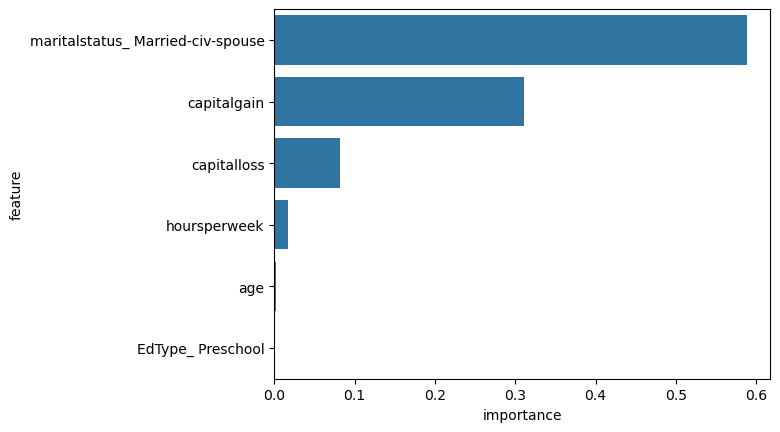

In [9]:
import seaborn as sns

sns.barplot(importance_df[:6], x="importance", y="feature")

# Assignment 2: Hyperparameter Tuning

1. Use cross validation to find the optimal tree parameters. Your process should evaluate different values of max_depth, 'min_samples_leaf', and 'criterion'. 
2. Generate a confusion matrix and report test accuracy, precision, and recall

In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth": [8, 10, 12],
    "min_samples_leaf": [22, 25, 30],
    "criterion": ["gini"]
}

grid = GridSearchCV(DecisionTreeClassifier(), params)

grid.fit(X_train, y_train)

grid.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 25}

In [11]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=25)

dt.fit(X_train, y_train)

dt.score(X_train, y_train)

0.8614650926432648

In [14]:
dt = DecisionTreeClassifier(**grid.best_params_)

dt.fit(X_train, y_train)

dt.score(X_train, y_train)

0.8614650926432648

In [15]:
confusion_matrix(y_test, dt.predict(X_test))

array([[4580,  301],
       [ 588,  927]])

In [16]:
from sklearn.metrics import precision_score, recall_score

print(f"Test Accuracy: {dt.score(X_test, y_test)}")
print(f"Test Precision: {precision_score(y_test, dt.predict(X_test))}")
print(f"Test Recall: {recall_score(y_test, dt.predict(X_test))}")

Test Accuracy: 0.8610068792995622
Test Precision: 0.754885993485342
Test Recall: 0.6118811881188119
